In [1]:
import pandas as pd
import seaborn as sns
import json

with open('stats.json','r') as f:
    stats = json.load(f)
    
df = pd.DataFrame(stats)
df.head()

,test,pearson,MSE,lang,timestamp
0,NILC_with_unk_../embeddings/NILC/glove/glove_s...,0.413119,0.630393,ptbr,1569071676
1,NILC_with_unk_../embeddings/NILC/glove/glove_s...,0.404266,0.980450,pteu,1569071681
2,NILC_with_unk_../embeddings/NILC/glove/glove_s...,0.474901,0.589540,ptbr,1569071692
3,NILC_with_unk_../embeddings/NILC/glove/glove_s...,0.435778,0.944158,pteu,1569071697
4,NILC_with_unk_../embeddings/NILC/glove/glove_s...,0.491512,0.577975,ptbr,1569071714


In [12]:
def get_embedding(x, idx):
    try:
        return x.split('/')[idx]
    except:
        return '0'

df['name'] = df['test'].apply(lambda x: get_embedding(x, 0))
df['embedding'] = df['test'].apply(lambda x: get_embedding(x, 3))
df['model'] = df['test'].apply(lambda x: get_embedding(x, 4).rstrip('.model'))
df['size'] = df['model'].apply(lambda x: int(''.join(filter(str.isdigit, x))) )
df.head()

,test,pearson,MSE,lang,timestamp,embedding,model,size,name
0,NILC_with_unk_../embeddings/NILC/glove/glove_s...,0.413119,0.630393,ptbr,1569071676,glove,glove_s50,50,NILC_with_unk_..
1,NILC_with_unk_../embeddings/NILC/glove/glove_s...,0.404266,0.980450,pteu,1569071681,glove,glove_s50,50,NILC_with_unk_..
2,NILC_with_unk_../embeddings/NILC/glove/glove_s...,0.474901,0.589540,ptbr,1569071692,glove,glove_s300,300,NILC_with_unk_..
3,NILC_with_unk_../embeddings/NILC/glove/glove_s...,0.435778,0.944158,pteu,1569071697,glove,glove_s300,300,NILC_with_unk_..
4,NILC_with_unk_../embeddings/NILC/glove/glove_s...,0.491512,0.577975,ptbr,1569071714,glove,glove_s600,600,NILC_with_unk_..


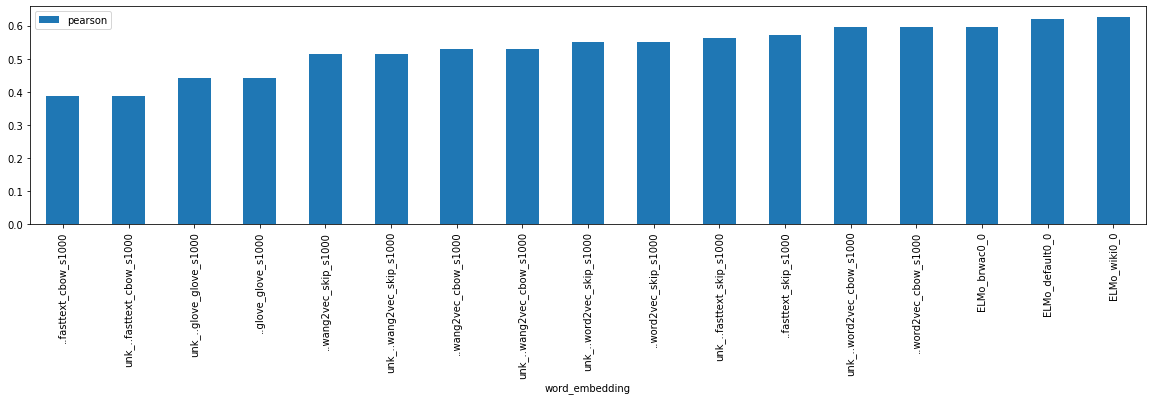

In [58]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)

dataplot = df[( df['embedding'].str.contains('0') | df['name'].str.startswith('NILC') )]
dataplot = dataplot[dataplot['lang'].str.contains('pteu')]
dataplot[ ( dataplot['size'] == 1000 ) | ( dataplot['size'] == 0 )]
dataplot['plot_name'] = dataplot['name'].combine(dataplot['embedding'], lambda x,y : x + y if y != 0 else x)
dataplot['plot_name'] = dataplot['plot_name'].combine(dataplot['model'], lambda x,y : x + '_' + y if y != 0 else x)
# dataplot['plot_name'] = dataplot['plot_name'].apply(lambda x: x.rstrip('_0_0'))
dataplot['plot_name'] = dataplot['plot_name'].apply(lambda x: x.lstrip('NILC'))
dataplot['plot_name'] = dataplot['plot_name'].apply(lambda x: x.lstrip('NILC_with_'))
dataplot = dataplot[ ( dataplot['plot_name'].str.endswith('s1000') | dataplot['plot_name'].str.endswith('0_0') ) ]
dataplot = dataplot.sort_values(by='pearson')
dataplot = dataplot.rename(columns={"plot_name": "word_embedding"})

dataplot.plot(x='word_embedding', y='pearson', kind='bar')